In [3]:
import py21cmcast as p21c
import numpy as np 

from astropy import units

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## II. Define the grid of modes and redshifts

In [4]:
z_bins, z_centers, k_bins = p21c.define_grid_modes_redshifts(6., 8 * units.MHz, z_max = 22, k_min = 0.1 / units.Mpc, k_max = 1 / units.Mpc)

fiducial = [None] * 2

fiducial[0]= p21c.Fiducial("../runs/CONSTRAINT_BKR_ELECTRON", z_bins, z_centers, k_bins, False, load = True)
fiducial[1] = p21c.Fiducial("../runs/CONSTRAINT_BKR_ELECTRON", z_bins, z_centers, k_bins, False, load = True)

for fid in fiducial:
    fid.observation = 'HERA'

## Classical sets of parameters
parameter_names_clas = ['F_STAR10', 'ALPHA_STAR', 'F_ESC10', 'ALPHA_ESC',  'M_TURN', 't_STAR', 'L_X', 'NU_X_THRESH']
parameter_names_mini_1 = ['F_STAR10', 'F_STAR7_MINI', 'ALPHA_STAR', 'ALPHA_STAR_MINI',  't_STAR', 'F_ESC10', 'F_ESC7_MINI', 'ALPHA_ESC', 'L_X', 'L_X_MINI', 'NU_X_THRESH']
parameter_names_mini_2 = ['F_STAR10', 'ALPHA_STAR', 'F_ESC10', 'ALPHA_ESC', 'F_STAR7_MINI', 'ALPHA_STAR_MINI', 'F_ESC7_MINI',  'A_LW', 'L_X', 'NU_X_THRESH']

parameter_names = [parameter_names_clas, parameter_names_clas]
params = [[None] * len(parameter_names[i])  for i, _ in enumerate(fiducial)]

for ifid, fid in enumerate(fiducial):
    for iname, name in enumerate(parameter_names[ifid]) :  
        params[ifid][iname] = p21c.Parameter(fiducial=fid, name=name, verbose = False, plot = False, load=True)

extra_names  = ['m8.0', 'm8.0']
values        = [1e-29, 1e-29]
extra_params = [None] * len(extra_names)

for iname, extra_name in enumerate(extra_names) :  
    extra_params[iname] = p21c.Parameter(fiducial=fiducial[iname], name='DM_DECAY_RATE', verbose = False, plot=False, load=True, add_name = extra_name, values=values[iname])

Treating parameter F_STAR10
Treating parameter ALPHA_STAR
Treating parameter F_ESC10
Treating parameter ALPHA_ESC
Treating parameter M_TURN
Treating parameter t_STAR
Treating parameter L_X
Treating parameter NU_X_THRESH
Treating parameter F_STAR10
Treating parameter ALPHA_STAR
Treating parameter F_ESC10
Treating parameter ALPHA_ESC
Treating parameter M_TURN
Treating parameter t_STAR
Treating parameter L_X
Treating parameter NU_X_THRESH
Treating parameter DM_DECAY_RATE (m8.0)
Treating parameter DM_DECAY_RATE (m8.0)


{'F_STAR10': {'F_STAR10': 0.09945459079234203, 'ALPHA_STAR': -0.00833732735944004, 'F_ESC10': -0.1055541006134759, 'ALPHA_ESC': -0.0029062714362530846, 'M_TURN': 0.017365577269854392, 't_STAR': 0.1143165296005295, 'L_X': 0.002235443243469334, 'NU_X_THRESH': -0.9845915856058188}, 'ALPHA_STAR': {'F_STAR10': -0.008337327359440753, 'ALPHA_STAR': 0.009248183780946533, 'F_ESC10': 0.00750972614348119, 'ALPHA_ESC': -0.010051847686020507, 'M_TURN': -0.005251357220737462, 't_STAR': -0.014496063685097779, 'L_X': -0.0014736761314054561, 'NU_X_THRESH': 1.6188352623627373}, 'F_ESC10': {'F_STAR10': -0.10555410061347606, 'ALPHA_STAR': 0.007509726143480471, 'F_ESC10': 0.11285240453852267, 'ALPHA_ESC': 0.005686269613047888, 'M_TURN': -0.016926359027780166, 't_STAR': -0.1203972306330188, 'L_X': -0.0015318098080029225, 'NU_X_THRESH': 1.1016872063448766}, 'ALPHA_ESC': {'F_STAR10': -0.0029062714362525573, 'ALPHA_STAR': -0.010051847686020571, 'F_ESC10': 0.0056862696130473185, 'ALPHA_ESC': 0.01708485562558116

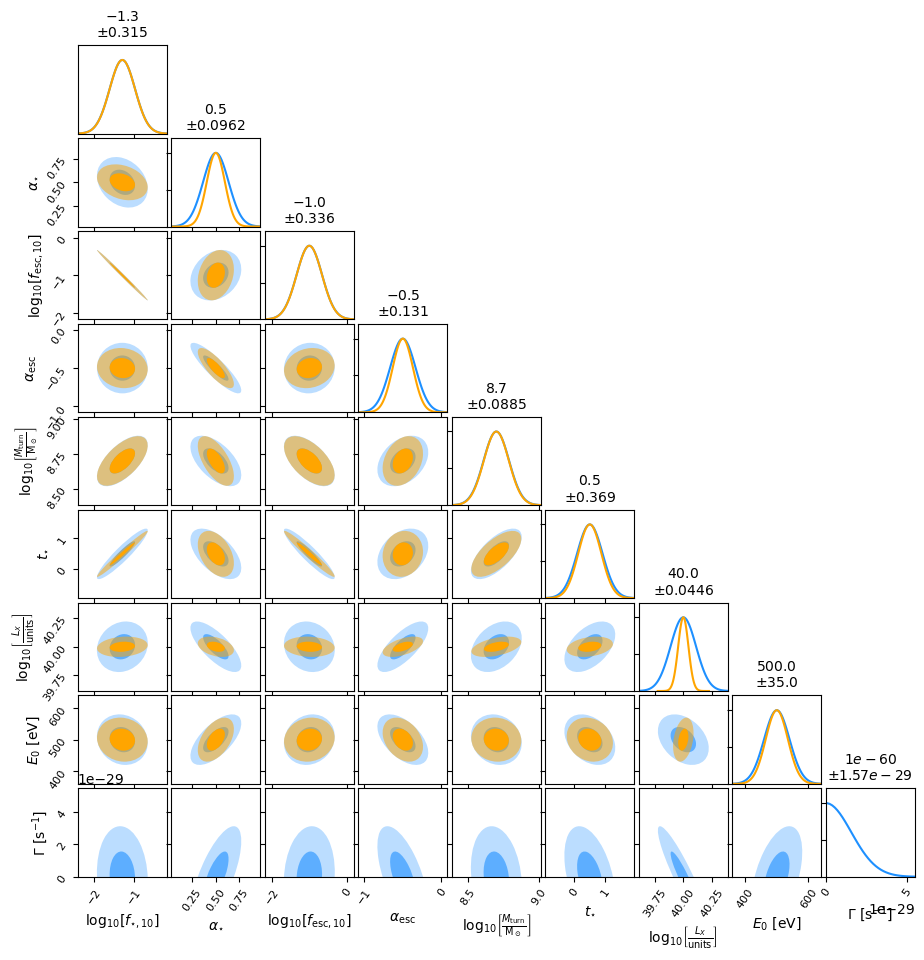

In [7]:
sigma_tau = np.zeros(len(fiducial))

fisher_matrix = [None] * len(fiducial)
covariance_matrix = [None] * len(fiducial)

for ifid, fid in enumerate(fiducial) : 
    fiducial[ifid].frac_noise = 0.2
    if ifid == 0:
        fisher_matrix[ifid]     = p21c.evaluate_fisher_matrix(params[ifid])
    else: 
        fisher_matrix[ifid]     = p21c.evaluate_fisher_matrix([*params[ifid], extra_params[ifid]])

    covariance_matrix[ifid] = np.linalg.inv(fisher_matrix[ifid]['matrix'])
    sigma_tau[ifid]         = 1/(2.*np.sqrt(covariance_matrix[ifid][-1][-1]))

covariance_dict = [{} for fid in fiducial]

# Transform the covariance matrix into covariance dictionnaries that can be plotted
for ifid, fid in enumerate(fiducial):
    for i, name_i in enumerate(fisher_matrix[ifid]['name']):
        covariance_dict[ifid][name_i] = {}
        for j, name_j in enumerate(fisher_matrix[ifid]['name']):
            covariance_dict[ifid][name_i][name_j] = covariance_matrix[ifid][i, j]

print(covariance_dict[0])
print(covariance_dict[1])

print([fid.astro_params for fid in fiducial])

%matplotlib inline
fig = p21c.make_triangle_plot([covariance_dict[1], covariance_dict[0]], [fid.astro_params for fid in fiducial], color=[ 'dodgerblue', 'orange',], alpha=[0.6, 1], params_to_plot = ['F_STAR10', 'ALPHA_STAR', 'F_ESC10', 'ALPHA_ESC',  'M_TURN', 't_STAR', 'L_X', 'NU_X_THRESH', 'DM_DECAY_RATE'])
fig.savefig('triangle_plot_paper.pdf', bbox_inches='tight')

In [9]:
z_bins, z_centers, k_bins = p21c.define_grid_modes_redshifts(6., 8 * units.MHz, z_max = 22, k_min = 0.1 / units.Mpc, k_max = 1 / units.Mpc)

fiducial = [None] * 2

fiducial[0]= p21c.Fiducial("../runs/CONSTRAINT_BKR_MINIHALOS", z_bins, z_centers, k_bins, False, load = True)
fiducial[1] = p21c.Fiducial("../runs/CONSTRAINT_BKR_MINIHALOS", z_bins, z_centers, k_bins, False, load = True)

for fid in fiducial:
    fid.observation = 'HERA'

## Classical sets of parameters
parameter_names_clas = ['F_STAR10', 'ALPHA_STAR', 'F_ESC10', 'ALPHA_ESC',  'M_TURN', 't_STAR', 'L_X', 'NU_X_THRESH']
parameter_names_mini_1 = ['F_STAR10', 'F_STAR7_MINI', 'ALPHA_STAR', 'ALPHA_STAR_MINI',  't_STAR', 'F_ESC10', 'F_ESC7_MINI', 'ALPHA_ESC', 'L_X', 'L_X_MINI', 'NU_X_THRESH']
parameter_names_mini_2 = ['F_STAR10', 'ALPHA_STAR', 'F_ESC10', 'ALPHA_ESC', 'F_STAR7_MINI', 'ALPHA_STAR_MINI', 'F_ESC7_MINI',  'A_LW', 'L_X', 'NU_X_THRESH']

parameter_names = [parameter_names_mini_1, parameter_names_mini_1]
params = [[None] * len(parameter_names[i])  for i, _ in enumerate(fiducial)]

for ifid, fid in enumerate(fiducial):
    for iname, name in enumerate(parameter_names[ifid]) :  
        params[ifid][iname] = p21c.Parameter(fiducial=fid, name=name, verbose = False, plot = False, load=True)

extra_names  = ['m8.0', 'm8.0']
values        = [5e-29, 5e-29]
extra_params = [None] * len(extra_names)

for iname, extra_name in enumerate(extra_names) :  
    extra_params[iname] = p21c.Parameter(fiducial=fiducial[iname], name='DM_DECAY_RATE', verbose = False, plot=False, load=True, add_name = extra_name, values=values[iname])

 py21cmcast/core.py:170: z-array in input is different than the one used to precompute the tables (UserWarning)
2023-05-23 14:54:08,618 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


Treating parameter F_STAR10
recomputing the tables with the new bins


2023-05-23 14:54:29,513 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


recomputing the tables with the new bins


2023-05-23 14:54:49,583 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


Treating parameter F_STAR7_MINI
recomputing the tables with the new bins


2023-05-23 14:55:09,767 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


recomputing the tables with the new bins


2023-05-23 14:55:30,218 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


Treating parameter ALPHA_STAR
recomputing the tables with the new bins


2023-05-23 14:55:50,318 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


recomputing the tables with the new bins


2023-05-23 14:56:10,321 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


Treating parameter ALPHA_STAR_MINI
recomputing the tables with the new bins


2023-05-23 14:56:30,543 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


recomputing the tables with the new bins


2023-05-23 14:56:50,515 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


Treating parameter t_STAR
recomputing the tables with the new bins


2023-05-23 14:57:10,532 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


recomputing the tables with the new bins


2023-05-23 14:57:30,608 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


Treating parameter F_ESC10
recomputing the tables with the new bins


2023-05-23 14:57:50,567 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


recomputing the tables with the new bins


2023-05-23 14:58:10,616 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


Treating parameter F_ESC7_MINI
recomputing the tables with the new bins


2023-05-23 14:58:31,354 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


recomputing the tables with the new bins


2023-05-23 14:58:51,466 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


Treating parameter ALPHA_ESC
recomputing the tables with the new bins


2023-05-23 14:59:11,505 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


recomputing the tables with the new bins


2023-05-23 14:59:31,623 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


Treating parameter L_X
recomputing the tables with the new bins


2023-05-23 14:59:51,779 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


recomputing the tables with the new bins


2023-05-23 15:00:12,073 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


Treating parameter L_X_MINI
recomputing the tables with the new bins


2023-05-23 15:00:32,191 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


recomputing the tables with the new bins


2023-05-23 15:00:52,247 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


Treating parameter NU_X_THRESH
recomputing the tables with the new bins


2023-05-23 15:01:12,518 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


recomputing the tables with the new bins


2023-05-23 15:01:32,747 | WARNING | inputs.py::__init__() | USE_MINI_HALOS needs USE_RELATIVE_VELOCITIES to get the right evolution!


Treating parameter F_STAR10
Treating parameter F_STAR7_MINI
Treating parameter ALPHA_STAR
Treating parameter ALPHA_STAR_MINI
Treating parameter t_STAR
Treating parameter F_ESC10
Treating parameter F_ESC7_MINI
Treating parameter ALPHA_ESC
Treating parameter L_X
Treating parameter L_X_MINI
Treating parameter NU_X_THRESH
Treating parameter DM_DECAY_RATE (m8.0)
recomputing the tables with the new bins
Treating parameter DM_DECAY_RATE (m8.0)


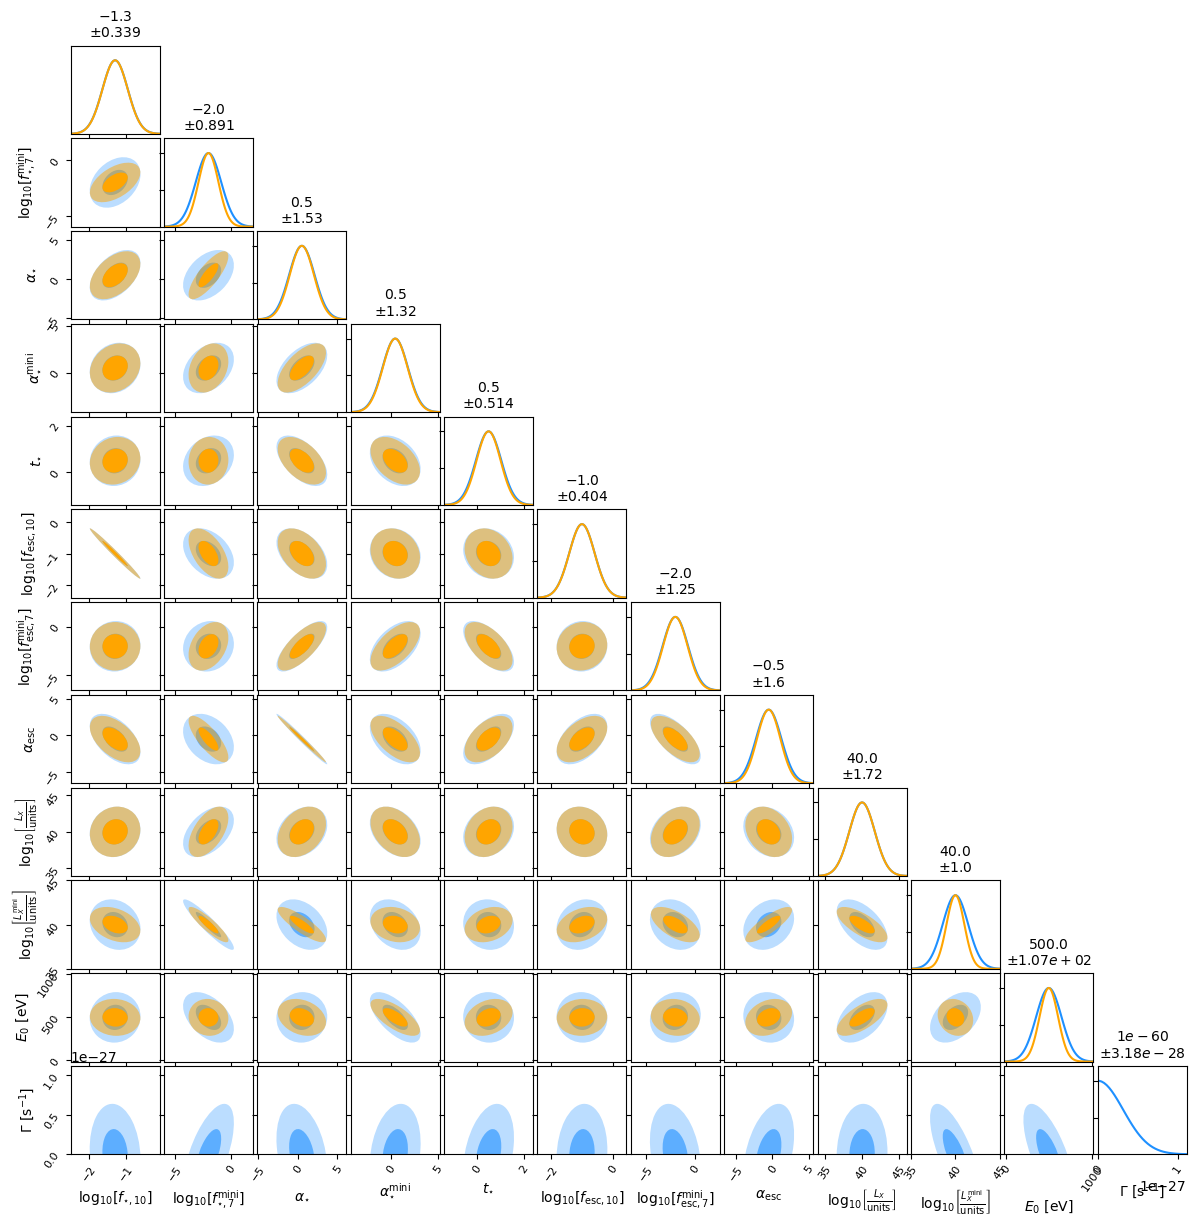

In [10]:
sigma_tau = np.zeros(len(fiducial))

fisher_matrix = [None] * len(fiducial)
covariance_matrix = [None] * len(fiducial)

for ifid, fid in enumerate(fiducial) : 
    fiducial[ifid].frac_noise = 0.2
    if ifid == 0:
        fisher_matrix[ifid]     = p21c.evaluate_fisher_matrix(params[ifid])
    else: 
        fisher_matrix[ifid]     = p21c.evaluate_fisher_matrix([*params[ifid], extra_params[ifid]])

    covariance_matrix[ifid] = np.linalg.inv(fisher_matrix[ifid]['matrix'])
    sigma_tau[ifid]         = 1/(2.*np.sqrt(covariance_matrix[ifid][-1][-1]))

covariance_dict = [{} for fid in fiducial]

# Transform the covariance matrix into covariance dictionnaries that can be plotted
for ifid, fid in enumerate(fiducial):
    for i, name_i in enumerate(fisher_matrix[ifid]['name']):
        covariance_dict[ifid][name_i] = {}
        for j, name_j in enumerate(fisher_matrix[ifid]['name']):
            covariance_dict[ifid][name_i][name_j] = covariance_matrix[ifid][i, j]


%matplotlib inline
fig = p21c.make_triangle_plot([covariance_dict[1], covariance_dict[0]], [fid.astro_params for fid in fiducial], color=[ 'dodgerblue', 'orange',], alpha=[0.6, 1], params_to_plot = ['F_STAR10', 'F_STAR7_MINI', 'ALPHA_STAR', 'ALPHA_STAR_MINI',  't_STAR', 'F_ESC10', 'F_ESC7_MINI', 'ALPHA_ESC', 'L_X', 'L_X_MINI', 'NU_X_THRESH', 'DM_DECAY_RATE'])
fig.savefig('triangle_plot_paper_minihalos.pdf', bbox_inches='tight')

In [22]:
import copy

cov0 = copy.deepcopy(covariance_dict[0])
cov1 = copy.deepcopy(covariance_dict[1])
astro_p = copy.deepcopy(fiducial[0].astro_params) 

for key in cov0.keys() : 
    cov0['NU_X_THRESH'][key]   = 1e-3 *  cov0['NU_X_THRESH'][key]
    cov0[key]['NU_X_THRESH']   = 1e-3 *  cov0[key]['NU_X_THRESH']

for key in cov1.keys() : 
    cov1['DM_DECAY_RATE'][key] = 1e+29 * cov1['DM_DECAY_RATE'][key] 
    cov1[key]['DM_DECAY_RATE'] = 1e+29 * cov1[key]['DM_DECAY_RATE'] 
    cov1['NU_X_THRESH'][key]   = 1e-3 *  cov1['NU_X_THRESH'][key]
    cov1[key]['NU_X_THRESH']   = 1e-3 *  cov1[key]['NU_X_THRESH']

astro_p['DM_DECAY_RATE'] = 0
astro_p['NU_X_THRESH'] = 0.5

print(cov0)
print(cov1)
print(astro_p)

{'F_STAR10': {'F_STAR10': 0.11523313918397367, 'F_STAR7_MINI': 0.1552900497214807, 'ALPHA_STAR': 0.24081719332777693, 'ALPHA_STAR_MINI': 0.08530259182392906, 't_STAR': 0.018124572789247173, 'F_ESC10': -0.13556793875505013, 'F_ESC7_MINI': 0.0006132077558387841, 'ALPHA_ESC': -0.27976881179298185, 'L_X': 0.052227053951927616, 'L_X_MINI': -0.11838231567529668, 'NU_X_THRESH': -0.0019179888126193755}, 'F_STAR7_MINI': {'F_STAR10': 0.15529004972166754, 'F_STAR7_MINI': 0.7946347129491628, 'ALPHA_STAR': 1.075557074135846, 'ALPHA_STAR_MINI': 0.3177792901232446, 't_STAR': 0.017729549746064558, 'F_ESC10': -0.19228889113250652, 'F_ESC7_MINI': 0.39173332354018753, 'ALPHA_ESC': -1.1122592764591597, 'L_X': 0.84361412223019, 'L_X_MINI': -0.7925856419812276, 'NU_X_THRESH': -0.005518897197835513}, 'ALPHA_STAR': {'F_STAR10': 0.2408171933281456, 'F_STAR7_MINI': 1.0755570741357992, 'ALPHA_STAR': 2.3394741336513776, 'ALPHA_STAR_MINI': 1.2571412988449855, 't_STAR': -0.38909358867198635, 'F_ESC10': -0.267708468